In [16]:
import pandas as pd
import os

ep4 = pd.read_csv('SW_EpisodeIV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep5 = pd.read_csv('SW_EpisodeV.txt', delimiter='\t', header=None, names=['character/dialogue'])
ep6 = pd.read_csv('SW_EpisodeVI.txt', delimiter='\t', header=None, names=['character/dialogue'])
episodes = [ep4, ep5, ep6]

In [21]:
ep4

,character/dialogue
0,"character ""dialogue"""
1,"1 ""THREEPIO"" ""Did you hear that? They've shut..."
2,"2 ""THREEPIO"" ""We're doomed!"""
3,"3 ""THREEPIO"" ""There'll be no escape for the Pr..."
4,"4 ""THREEPIO"" ""What's that?"""
...,...
1006,"1006 ""LUKE"" ""Oh, no!"""
1007,"1007 ""THREEPIO"" ""Oh, my! Artoo! Can you hear..."
1008,"1008 ""TECHNICIAN"" ""We'll get to work on him ri..."
1009,"1009 ""THREEPIO"" ""You must repair him! Sir, if..."


In [30]:
def convertToProperDf(df):
    texts = df["character/dialogue"][1:]
    characters = []
    dialogues = []
    for text in texts:
        tup = [t.strip('"') for t in text.split('"') if t.strip()]
        new_tup = (tup[0], tup[1], " ".join(tup[2:]))
        number, character, dialogue = new_tup
        characters.append(character)
        dialogues.append(dialogue)
    new_df = pd.DataFrame({'character': characters, 'dialogue': dialogues})
    return new_df

cleaned_episodes = [convertToProperDf(episode) for episode in episodes]
cleaned_episodes[0]

,character,dialogue
0,THREEPIO,Did you hear that? They've shut down the main...
1,THREEPIO,We're doomed!
2,THREEPIO,There'll be no escape for the Princess this time.
3,THREEPIO,What's that?
4,THREEPIO,I should have known better than to trust the l...
...,...,...
1005,LUKE,"Oh, no!"
1006,THREEPIO,"Oh, my! Artoo! Can you hear me? Say somethi..."
1007,TECHNICIAN,We'll get to work on him right away.
1008,THREEPIO,"You must repair him! Sir, if any of my circui..."


In [43]:
cleaned_episodes[0].to_csv('SW_EpisodeIV.csv', sep=";", index=False)
cleaned_episodes[1].to_csv('SW_EpisodeV.csv', sep=";", index=False)
cleaned_episodes[2].to_csv('SW_EpisodeVI.csv', sep=";", index=False)

In [78]:
def findNodes(name, df):
    nunique = df.character.unique().tolist()
    print(f"Number of unique characters for {name}: ", len(nunique))
    return nunique

def findLinks(name, df):
    links = []
    dialogues = df.character.tolist()
    for i in range(2, len(dialogues)-1):
        characters = list(set(dialogues[i-2:i+1]))
        if len(characters) < 2:
            continue
        if [characters[0], characters[1]] not in links:
            links.append([characters[0], characters[1]])
        if len(characters) < 3:
            continue
        if [characters[0], characters[2]] not in links:
            links.append([characters[0], characters[2]])
    print(f"Number of links for {name}: ", len(links))
    return links

import operator

def top10Links(name, nodes, links):
    number_of_links = {key: 0 for key in nodes}
    for i in range(len(links)):
        # to avoid duplicates
        if [links[i][1], links[i][0]] not in links[:i]:
            number_of_links[links[i][0]] += 1
            number_of_links[links[i][1]] += 1
    inverse = [(value, key) for key, value in number_of_links.items()]
    top10 = sorted(inverse, key=operator.itemgetter(0), reverse=True)[:10]
    return top10

import matplotlib.pyplot as plt

def plotTopLinks(names, topLinks):
    for name, topLink in zip(names, topLinks):
        x = [t[1] for t in topLink]
        y = [t[0] for t in topLink]
        plt.bar(x,y)
        plt.title(f"Top 10 links for {name}")
        plt.xlabel("Character")
        plt.ylabel("Number of links")
        plt.xticks(fontsize=8, rotation=45)
        plt.show()

In [79]:
names = ["Episode IV", "Episode V", "Episode VI"]
nodes = [findNodes(name, ep) for name, ep in zip(names, cleaned_episodes)]
links = [findLinks(name, ep) for name, ep in zip(names, cleaned_episodes)]

Number of unique characters for Episode IV:  60
Number of unique characters for Episode V:  49
Number of unique characters for Episode VI:  53
Number of links for Episode IV:  202
Number of links for Episode V:  138
Number of links for Episode VI:  158


In [80]:
print("Total number of nodes: ", sum([len(node) for node in nodes]))
print("Total number of links: ", sum([len(link) for link in links]))
LinksTop10 = [top10Links(name, node, link) for name, node, link in zip(names, nodes, links)]

Total number of nodes:  162
Total number of links:  498


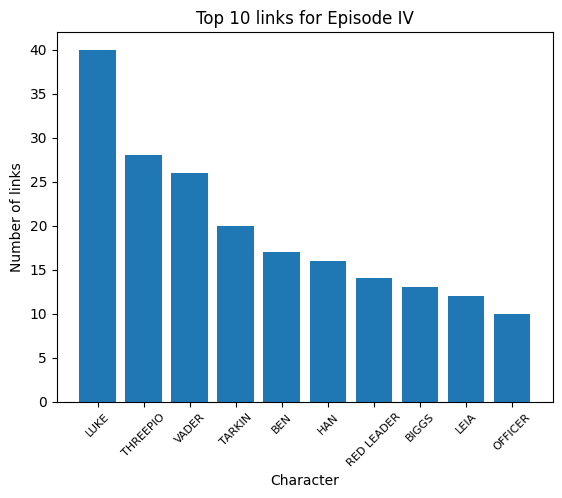

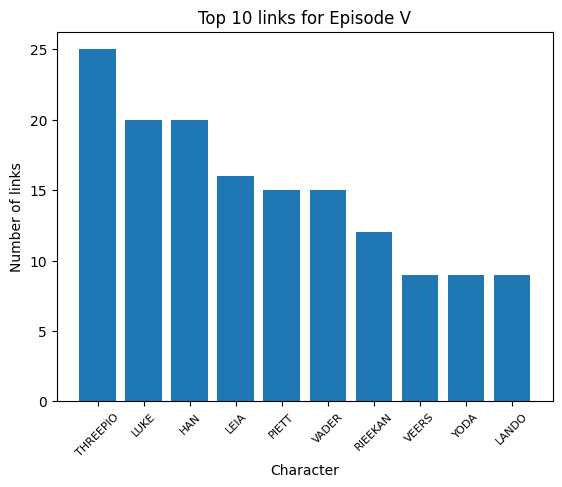

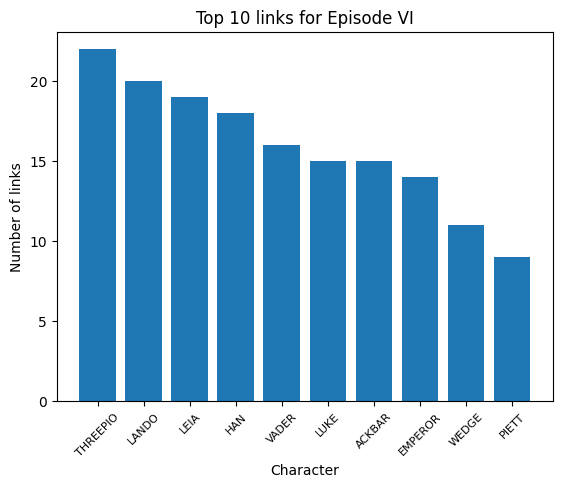

In [81]:
plotTopLinks(names, LinksTop10)

We will now try to make a temporal by looking a some of the most important characters and how their links to other characters develop over time:

In [128]:
def number_of_links_over_time(character, links):
    character_name = character.upper()
    all_nodes = []
    all_links = []
    nodes_for_each_ep = []
    links_for_each_ep = []
    for links_for_ep in links:
        
        for link in links_for_ep:
            if link[0] == character_name:
                nodes_for_each_ep.append(link[1])
            if link[1] == character_name:
                nodes_for_each_ep.append(link[0])
            if character_name in link:
                links_for_each_ep.append(tuple(link))
        print(nodes_for_each_ep)
        all_nodes.append(nodes_for_each_ep)
        all_links.append(links_for_each_ep)
    print([len(node) for node in all_nodes])
    return all_nodes, all_links

In [129]:
import networkx as nx
import netwulf

def make_graph(nodes, links):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(links)
    return G

def draw_graphs(graphs):
    fig, axs = plt.subplots(1, len(graphs), figsize=(5*len(graphs), 5))
    for i, graph in enumerate(graphs):
        nx.draw(graph, with_labels=True, ax=axs[i])
        axs[i].set_title(f'Episode {i}')

nodes_for_each_ep, links_for_each_ep = number_of_links_over_time("LUKE", links)
print(*[(len(node), len(link)) for node, link in zip(nodes_for_each_ep, links_for_each_ep)], sep="\n")

['THREEPIO', 'THREEPIO', 'CAMIE', 'FIXER', 'BIGGS', 'DEAK', 'BERU', 'OWEN', 'LEIA', 'AUNT BERU', 'BEN', 'TAGGE', 'TARKIN', 'VADER', 'TROOPER', 'BARTENDER', 'CREATURE', 'HUMAN', 'HAN', 'GREEDO', 'JABBA', 'MOTTI', 'VADER', 'TARKIN', 'OFFICER', 'GANTRY OFFICER', 'TROOPER VOICE', 'FIRST TROOPER', 'WILLARD', 'DODONNA', 'WEDGE', 'DEATH STAR INTERCOM VOICE', 'MAN', 'RED LEADER', 'CHIEF', 'CHIEF', 'RED ELEVEN', 'ASTRO-OFFICER', 'CONTROL OFFICER', 'RED TEN', 'GOLD LEADER', 'BASE VOICE', 'MASSASSI INTERCOM VOICE', 'TECHNICIAN']
['THREEPIO', 'THREEPIO', 'CAMIE', 'FIXER', 'BIGGS', 'DEAK', 'BERU', 'OWEN', 'LEIA', 'AUNT BERU', 'BEN', 'TAGGE', 'TARKIN', 'VADER', 'TROOPER', 'BARTENDER', 'CREATURE', 'HUMAN', 'HAN', 'GREEDO', 'JABBA', 'MOTTI', 'VADER', 'TARKIN', 'OFFICER', 'GANTRY OFFICER', 'TROOPER VOICE', 'FIRST TROOPER', 'WILLARD', 'DODONNA', 'WEDGE', 'DEATH STAR INTERCOM VOICE', 'MAN', 'RED LEADER', 'CHIEF', 'CHIEF', 'RED ELEVEN', 'ASTRO-OFFICER', 'CONTROL OFFICER', 'RED TEN', 'GOLD LEADER', 'BASE V

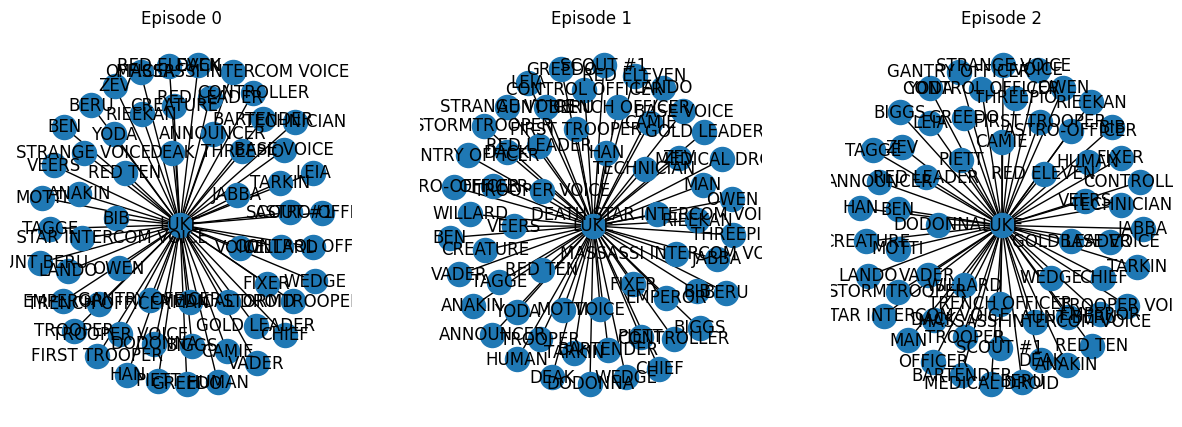

In [115]:
graphs = [make_graph(node, link) for node, link in zip(nodes_for_each_ep, links_for_each_ep)]
draw_graphs(graphs)